In [2]:
import imp
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import h5py

import util
from plot_core import PlotAx, STYLE_PATH
from util import *
from plot_model_training import *

%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

ImportError: DLL load failed: 找不到指定的程序。

In [2]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from keras import models
from keras import layers

Using TensorFlow backend.


In [3]:
style_file = os.path.join(STYLE_PATH, 'plot_regression.mplstyle')
plt.style.use(style_file)

In [4]:
in_dir = '/home/cali/data/GapFilling/GIIRSFull/'
pic_dir = 'Picture/'
result_dir = 'Result/'
data_dir = 'Data/'
model_dir = 'Model'
for _dir in [pic_dir, pic_dir, result_dir, data_dir, model_dir]:
    if not os.path.isdir(_dir):
        os.makedirs(_dir)

# 合成全部的CRIS_full数据

In [5]:
def combine_full_data(in_files, out_file):
    """
    合成全部的CRIS_full数据
    :param y_ranges: 
    :param x_ranges: 
    :param in_files:
    :param out_file:
    :return:
    """
    data_all = None
    wavenumber = None
    for in_file in in_files:
        with h5py.File(in_file, 'r') as hdf5_r:
            data = hdf5_r.get('spectrum_radiance')[:].astype(np.float32)
            if data_all is None:
                data_all = data
            else:
                data_all = np.concatenate((data_all, data), axis=0)
            if wavenumber is None:
                wavenumber = hdf5_r.get('spectrum_wavenumber')[:].astype(np.float32)

    compression = 'gzip'  # 压缩算法种类
    compression_opts = 1  # 压缩等级
    shuffle = True
    with h5py.File(out_file, 'w') as hdf5:
        hdf5.create_dataset('spectrum_radiance',
                            dtype=np.float32, data=data_all, compression=compression,
                            compression_opts=compression_opts,
                            shuffle=shuffle)
        hdf5.create_dataset('spectrum_wavenumber',
                            dtype=np.float32, data=wavenumber, compression=compression,
                            compression_opts=compression_opts,
                            shuffle=shuffle)

In [41]:
filenames = os.listdir(in_dir)
in_files = [os.path.join(in_dir, filename) for filename in filenames if 'ipynb' not in filename]
in_files.sort()

full_data_file = os.path.join(data_dir, 'GIIRS_full_data_night.hdf')
if not os.path.isfile(full_data_file):
    combine_full_data(in_files, full_data_file)

# 加载全部波段数据

In [ ]:
def load_full_combine_data(in_file, sample_count=None):
    """
    读取并清洗数据
    """
    with h5py.File(in_file, 'r') as hdf5:
        if sample_count is None:
            spectrum_radiance = hdf5.get('spectrum_radiance')[:]
            spectrum_wavenumber = hdf5.get('spectrum_wavenumber')[:]
        else:
            e = int(sample_count)
            spectrum_radiance = hdf5.get('spectrum_radiance')[:e]
            spectrum_wavenumber = hdf5.get('spectrum_wavenumber')[:]

    spectrum_radiance = pd.DataFrame(spectrum_radiance, dtype='float32')
    return spectrum_radiance, spectrum_wavenumber

In [ ]:
data_all, wavenumber = load_full_combine_data(full_data_file, None)

In [ ]:
print(type(data_all))
print(type(wavenumber))

print(data_all.shape)
print(wavenumber.shape)

In [ ]:
# 判断是否有小于0和等于nan的无效值
print(np.where(data_all<=0)[0].shape)
print(np.where(wavenumber<=0)[0].shape)

print(np.where(np.isnan(data_all))[0].shape)
print(np.where(np.isnan(wavenumber))[0].shape)

In [ ]:
for i in range(0, 10):
    plt.plot(data_all.loc[i])
plt.show()

In [ ]:
for i in range(0, 10):
    plt.plot(rad2tbb(data_all.loc[i], wavenumber))
plt.show()

# 加载预测波段的数据

In [ ]:
def get_data_by_wavenumber_range(df_data, wavenumber, ranges):
    """
    根据波数和波数范围获取数据
    :param df_data: pd.DataFrame 格式
    :param wavenumber: 波数
    :param ranges: 波段范围和分辨率 [(start, end, frequency),]
    :return:
    """
    if not isinstance(df_data, pd.DataFrame):
        df_data = pd.DataFrame(df_data)
    
    wavenumber = wavenumber.tolist()
    idx = list()
    for range_s, range_e, _ in ranges:
        idx_s = wavenumber.index(range_s)
        idx_e = wavenumber.index(range_e)
        idx_tmp = [i for i in range(idx_s, idx_e+1)]
        if idx is None:
            idx = idx_tmp
        else:
            idx.extend(idx_tmp)
    return np.array(df_data.loc[:, idx])

In [ ]:
def load_train_data_from_all(data_all, wavenumber, ranges_x, ranges_y):
    """
    加载训练数据
    :param x_all:
    :param y_all:
    :param ranges_x_all:
    :param ranges_y_all:
    :param ranges_x:
    :param ranges_y:
    :return:
    """
    wavenumber_x = get_wavenumber_by_range(ranges_x)
    wavenumber_y = get_wavenumber_by_range(ranges_y)

    x = get_data_by_wavenumber_range(data_all, wavenumber, ranges_x)

    y = get_data_by_wavenumber_range(data_all, wavenumber, ranges_y)
    
    # 将数据分为训练集和测试集
    train_x, test_x, train_y, test_y = train_test_split(x, y, random_state=42, test_size=0.2)

    # 制作绘图用的切分X轴数据的index
    index_x = get_range_index_by_range(ranges_x)
    index_y = get_range_index_by_range(ranges_y)

    data = {
        'train_X': train_x,
        'test_X': test_x,
        'train_Y': train_y,
        'test_Y': test_y,
        'wavenumber_X': wavenumber_x,
        'wavenumber_Y': wavenumber_y,
        'index_X': index_x,
        'index_Y': index_y,
    }

    return data

In [ ]:
#### 所有测量通道和预测通道每一波段的范围和分辨率 (start, end, frequency)
# ranges_X_all = [(760., 1050., 0.625), (1800., 2188.125, 0.625),]
# ranges_Y_all = [(650, 699.375, 0.625), (700, 759.375, 0.625), (1050.625, 1130, 0.625),
#                 (1130.625, 1649.375, 0.625), (1650., 1799.375, 0.625), (2188.75, 2250., 0.625),
#                (2250.625, 2755., 0.625),]

# ranges_X_all = [(760., 1050., 0.625), (1800., 2188.125, 0.625),]
# ranges_Y_all = [(700, 759.375, 0.625), (1050.625, 1130, 0.625),
#                 (1130.625, 1649.375, 0.625), (1650., 1799.375, 0.625), (2188.75, 2250., 0.625),
#                ]

ranges_X_all = [(648.75, 1136.25, 0.625), (1208.75, 1751.25, 0.625), (2153.75, 2551.25, 0.625),]
# ranges_Y_all = [(1136.875, 1208.125, 0.625), (1751.875, 2153.125, 0.625), (2551.875, 2755., 0.625), ]


# ranges_X_all = [(650., 1135., 0.625), (1207.50, 1750., 0.625), (2152.50, 2550., 0.625),]
# ranges_Y_all = [(1135.625, 1206.875, 0.625), (1750.625, 2151.875, 0.625), (2550.625, 2755., 0.625), ]


ranges_X_all = [(650., 1135., 0.625), (1210., 1750., 0.625), (2155., 2550., 0.625),]
ranges_Y_all = [(1135.625, 1209.375, 0.625), (1750.625, 2154.375, 0.625), (2550.625, 2755., 0.625), ]

# 当前测量通道和预测通道每一波段的范围和分辨率 (start, end, frequency)
ranges_X = ranges_X_all
# ranges_X = [(650., 1095, 0.625), ]
# ranges_X = [(1210., 1750, 0.625), ]
# ranges_X = [(2155., 2550., 0.625), ]
ranges_Y = ranges_Y_all
# ranges_Y = [(1095.625, 1209.375, 0.625), ]
# ranges_Y = [(1750.625, 2154.375, 0.625), ]
# ranges_Y = [(2550.625, 2755., 0.625), ]

In [ ]:
for i, j, k in ranges_Y_all:
    print((j-i)/0.625 + 1)
for i, j, k in ranges_X_all:
    print((j-i)/0.625 + 1)

In [ ]:
data = load_train_data_from_all(data_all, wavenumber, ranges_X, ranges_Y)

In [ ]:
train_X = data['train_X']
test_X = data['test_X']
train_Y = data['train_Y']
test_Y = data['test_Y']
wavenumber_X = data['wavenumber_X']
wavenumber_Y = data['wavenumber_Y']
index_X = data['index_X']
index_Y = data['index_Y']

# 应用PCA

In [ ]:
# pca = PCA()
# pca.fit(train_X)
# explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
# plt.plot(explained_variance_ratio)
# print(np.where(explained_variance_ratio>0.99950))
# print(np.where(explained_variance_ratio>0.99990))
# plt.ylim(0.999, 1.)
# plt.show()

In [ ]:
pc_count = [110, 30, 190, 230]

In [ ]:
from sklearn.decomposition import PCA
x_pc = pc_count[0]
pca_x = PCA(x_pc)
train_X_pca = pca_x.fit_transform(train_X)
train_X_repreject = pca_x.inverse_transform(train_X_pca)
print(mean_squared_error(train_X, train_X_repreject))

In [ ]:
test_X_pca = pca_x.transform(test_X)
test_X_repreject = pca_x.inverse_transform(test_X_pca)
print(mean_squared_error(test_X, test_X_repreject))

In [ ]:
# 没有用错数据，但是Y重投影以后，与原来数据的差异特别大，这里需要Debug，目前怀疑是保留pc数量的问题
y_pc = pc_count[1:]

train_Y_repreject = None
test_Y_repreject = None

for y_pc_, [s, e] in zip(y_pc, index_Y):
    
#     pca = PCA()
#     pca.fit(train_Y[:, s:e])
#     explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
#     plt.plot(explained_variance_ratio)
#     plt.ylim(0.999, 1.)
#     print(np.where(explained_variance_ratio>0.99950))
#     print(np.where(explained_variance_ratio>0.99990))
#     plt.show()

    pca_y = PCA(y_pc_)
    y_part = train_Y[:, s:e]
    pca_y.fit(y_part)
    y_ = pca_y.transform(y_part)
    y_pca = pca_y.inverse_transform(y_)
    if train_Y_repreject is None:
        train_Y_repreject = y_pca
    else:
        train_Y_repreject = np.concatenate((train_Y_repreject, y_pca), axis=1)
    print(mean_squared_error(y_part, y_pca))

    y_part = test_Y[:, s:e]
    y_ = pca_y.transform(y_part)
    y_pca = pca_y.inverse_transform(y_)
    if test_Y_repreject is None:
        test_Y_repreject = y_pca
    else:
        test_Y_repreject = np.concatenate((test_Y_repreject, y_pca), axis=1)
    print(mean_squared_error(y_part, y_pca))

print(mean_squared_error(train_Y_repreject, train_Y))
print(mean_squared_error(test_Y_repreject, test_Y))

In [ ]:
figsize1 = (6.4, 2.5)

alpha = 0.5

for data_number in range(0, 2):
    count = 0
    fig = plt.figure(figsize=figsize1, dpi=150)
    plot_true_label = False
    plot_predict_label = False
    for s, e in index_X:
        plt.plot(wavenumber_X[s: e], train_X[data_number][s: e], 'b--', alpha=alpha)
    for s, e in index_Y:
        if plot_true_label:
            label=None
        else:
            label='true'
        plt.plot(wavenumber_X[s: e], train_X_repreject[data_number][s: e], 'r-.', alpha=alpha, label=label)
        plot_true_label = True
    for s, e in index_Y:
        if plot_predict_label:
            label=None
        else:
            label='predict'
        plt.plot(wavenumber_Y[s: e], train_Y[data_number][s: e], 'g--', alpha=alpha, label=label)
        plot_predict_label = True
    for s, e in index_Y:
        if plot_predict_label:
            label=None
        else:
            label='predict'
        plt.plot(wavenumber_Y[s: e], train_Y_repreject[data_number][s: e], 'y-.', alpha=alpha, label=label)
        plot_predict_label = True
    plt.xlabel('Wavenumber($cm^{-1}$)')
    plt.ylabel('TBB ($K$)')
    plt.legend()
    plt.show()

In [ ]:
train_X_tbb_repreject = rad2tbb(train_X_repreject, wavenumber_X)

In [ ]:
train_X_tbb = rad2tbb(train_X, wavenumber_X)

In [ ]:
train_Y_tbb_repreject = rad2tbb(train_Y_repreject, wavenumber_Y)

In [ ]:
train_Y_tbb = rad2tbb(train_Y, wavenumber_Y)

In [ ]:
test_X_tbb_repreject = rad2tbb(test_X_repreject, wavenumber_X)

In [ ]:
test_X_tbb = rad2tbb(test_X, wavenumber_X)

In [ ]:
test_Y_tbb_repreject = rad2tbb(test_Y_repreject, wavenumber_Y)

In [ ]:
test_Y_tbb = rad2tbb(test_Y, wavenumber_Y)

In [ ]:
figsize1 = (6.4, 2.5)

alpha = 0.5

for data_number in range(0, 2):
    count = 0
    fig = plt.figure(figsize=figsize1, dpi=150)
    plot_true_label = False
    plot_predict_label = False
    for s, e in index_X:
        if plot_true_label:
            label=None
        else:
            label='true'
        plt.plot(wavenumber_X[s: e], train_X_tbb[data_number][s: e], 'b-', alpha=alpha)
        plot_true_label = True
    for s, e in index_X:
        if plot_true_label:
            label=None
        else:
            label='true_repreject'
        plt.plot(wavenumber_X[s: e], train_X_tbb_repreject[data_number][s: e], 'r-.', alpha=alpha, label=label)
        plot_true_label = True
    for s, e in index_Y:
        if plot_predict_label:
            label=None
        else:
            label='predict'
        plt.plot(wavenumber_Y[s: e], train_Y_tbb[data_number][s: e], 'g-', alpha=alpha, label=label)
        plot_predict_label = True
    for s, e in index_Y:
        if plot_predict_label:
            label=None
        else:
            label='predict_repreject'
        plt.plot(wavenumber_Y[s: e], train_Y_tbb_repreject[data_number][s: e], 'y-.', alpha=alpha, label=label)
        plot_predict_label = True
    plt.xlabel('Wavenumber($cm^{-1}$)')
    plt.ylabel('TBB ($K$)')
    plt.legend()
    plt.show()

In [ ]:
figsize1 = (6.4, 2.5)

alpha = 0.5

for data_number in range(0, 2):
    count = 0
    fig = plt.figure(figsize=figsize1, dpi=150)
    plot_true_label = False
    plot_predict_label = False
    for s, e in index_X:
        if plot_true_label:
            label=None
        else:
            label='true'
        plt.plot(wavenumber_X[s: e], test_X_tbb[data_number][s: e], 'b-', alpha=alpha)
        plot_true_label = True
    for s, e in index_X:
        if plot_true_label:
            label=None
        else:
            label='true_repreject'
        plt.plot(wavenumber_X[s: e], test_X_tbb_repreject[data_number][s: e], 'r-.', alpha=alpha, label=label)
        plot_true_label = True
    for s, e in index_Y:
        if plot_predict_label:
            label=None
        else:
            label='predict'
        plt.plot(wavenumber_Y[s: e], test_Y_tbb[data_number][s: e], 'g-', alpha=alpha, label=label)
        plot_predict_label = True
    for s, e in index_Y:
        if plot_predict_label:
            label=None
        else:
            label='predict_repreject'
        plt.plot(wavenumber_Y[s: e], test_Y_tbb_repreject[data_number][s: e], 'y-.', alpha=alpha, label=label)
        plot_predict_label = True
    plt.xlabel('Wavenumber($cm^{-1}$)')
    plt.ylabel('TBB ($K$)')
    plt.legend()
    plt.show()

# 训练

In [42]:
model_data = {
    'train_X': train_X,
    'test_X': test_X,
    'train_Y': train_Y,
    'test_Y': test_Y,
}

In [43]:
print(index_X)
print(index_Y)

[[   0  777]
 [ 777 1642]
 [1642 2275]]
[[   0  119]
 [ 119  766]
 [ 766 1094]]


In [44]:
print(type(model_data['train_X']))
print(type(model_data['test_X']))
print(type(model_data['train_Y']))
print(type(model_data['test_Y']))
print(type(wavenumber_X))
print(type(wavenumber_Y))
print(type(index_X))
print(type(index_Y))

print(model_data['train_X'].shape)
print(model_data['test_X'].shape)
print(model_data['train_Y'].shape)
print(model_data['test_Y'].shape)
print(wavenumber_X.shape)
print(wavenumber_Y.shape)
print(index_X.shape)
print(index_Y.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(956951, 2275)
(239238, 2275)
(956951, 1094)
(239238, 1094)
(2275,)
(1094,)
(3, 2)
(3, 2)


In [45]:
print(np.where(model_data['train_X']<=0)[0].shape)
print(np.where(model_data['test_X']<=0)[0].shape)
print(np.where(model_data['train_Y']<=0)[0].shape)
print(np.where(model_data['test_Y']<=0)[0].shape)

print(np.where(np.isnan(model_data['train_X']))[0].shape)
print(np.where(np.isnan(model_data['test_X']))[0].shape)
print(np.where(np.isnan(model_data['train_Y']))[0].shape)
print(np.where(np.isnan(model_data['test_Y']))[0].shape)

(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)
(0,)


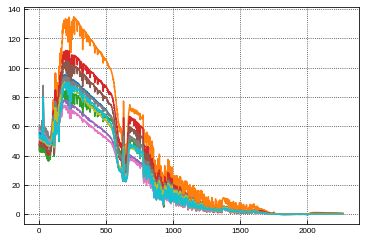

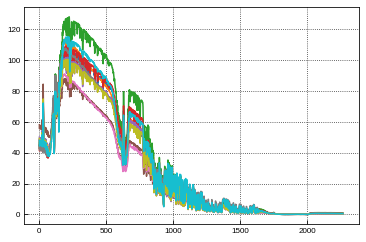

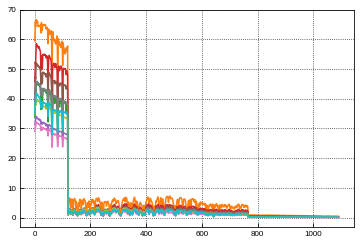

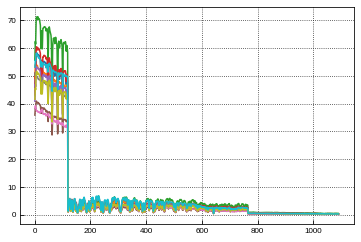

In [46]:
for i in range(0, 10):
    plt.plot(model_data['train_X'][i])
plt.show()
for i in range(0, 10):
    plt.plot(model_data['test_X'][i])
plt.show()
for i in range(0, 10):
    plt.plot(model_data['train_Y'][i])
plt.show()
for i in range(0, 10):
    plt.plot(model_data['test_Y'][i])
plt.show()

In [47]:
# 没有用错数据，但是Y重投影以后，与原来数据的差异特别大，这里需要Debug
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(model_data['train_X'], model_data['train_Y'])

print(lin_reg.coef_.T.shape)
print(lin_reg.intercept_.T.shape)

(2275, 1094)
(1094,)


In [48]:
predict_Y_linear = lin_reg.predict(model_data['test_X'])

In [49]:
gap_number = [i[1] - i[0] for i in index_Y]

In [50]:
def save_linear_model_attributes(coeff, intercept, out_file):
    """
    保存线性模型的属性
    :param coeff: 
    :param intercept: 
    :param out_file: 
    :return: 
    """
    compression = 'gzip'  # 压缩算法种类
    compression_opts = 1  # 压缩等级
    shuffle = True
    with h5py.File(out_file, 'w') as hdf5:
        hdf5.create_dataset('P0',
                            dtype=np.float32, data=coeff, compression=compression,
                            compression_opts=compression_opts,
                            shuffle=shuffle)
        hdf5.create_dataset('C0',
                            dtype=np.float32, data=intercept, compression=compression,
                            compression_opts=compression_opts,
                            shuffle=shuffle)
        hdf5.create_dataset('GAP_NUM',
                            dtype=np.int32, data=np.array(gap_number), compression=compression,
                            compression_opts=compression_opts,
                            shuffle=shuffle)

In [64]:
model_attribute_file = 'Model/linear_model_attribute_test_hiras_night.h5'
# u = pca_x.components_.T
# p = lin_reg.coef_.T
# coeff = np.dot(u, p)
# intercept = lin_reg.intercept_.T - pca_x.mean_.dot(coeff)

coeff = lin_reg.coef_.T
intercept = lin_reg.intercept_.T

print(coeff.shape)
print(intercept.shape)
save_linear_model_attributes(coeff, intercept, model_attribute_file)

(2275, 1094)
(1094,)


In [52]:
from sklearn.externals import joblib
# model_file = 'Model/linear_model_attribute_test_giirs_pca.pkl'
# joblib.dump(pca_x, model_file)

model_file = 'Model/linear_model_attribute_test_hiras_night_linear.pkl'
joblib.dump(lin_reg, model_file)

['Model/linear_model_attribute_test_hiras_night_linear.pkl']

In [53]:
mae = mean_absolute_error(model_data['test_Y'], predict_Y_linear)
mse = mean_squared_error(model_data['test_Y'], predict_Y_linear)
print(mae)
print(mse)

0.022463078
0.0018746995


In [54]:
# linear_model_attribute_file = os.path.join(model_dir, 'linear_model_attribute_business.h5')
# coef, intercept = get_linear_model_attributes(linear_model_attribute_file)

In [55]:
# lin_reg.coef_ = coef.T
# lin_reg.intercept_ = intercept.T
# predict_Y_linear = lin_reg.predict(test_X)

In [56]:
# mae = mean_absolute_error(test_Y, predict_Y_linear)
# mse = mean_squared_error(test_Y, predict_Y_linear)
# print(mae)
# print(mse)

In [57]:
# 去除预测结果中含无效值（<=0）的光谱
predict_Y_linear_tmp = predict_Y_linear.copy()
test_Y_linear_tmp = model_data['test_Y'].copy()
predict_Y_linear_tmp = pd.DataFrame(predict_Y_linear_tmp)
test_Y_linear_tmp = pd.DataFrame(test_Y_linear_tmp)
print(predict_Y_linear_tmp.shape)
print(test_Y_linear_tmp.shape)
index = predict_Y_linear_tmp <= 0
predict_Y_linear_tmp[index] = np.nan
test_Y_linear_tmp[index] = np.nan
predict_Y_linear_tmp = predict_Y_linear_tmp.dropna(axis=0)
test_Y_linear_tmp = test_Y_linear_tmp.dropna(axis=0)
print(predict_Y_linear_tmp.shape)
print(test_Y_linear_tmp.shape)

predict_Y_linear_tmp = np.array(predict_Y_linear_tmp)
test_Y_linear_tmp = np.array(test_Y_linear_tmp)

(239238, 1094)
(239238, 1094)
(239238, 1094)
(239238, 1094)


In [58]:
def plot_model_validate(tbb_test, tbb_predict, wavenumber, index, out_file):
    """
    对模型结果进行验证
    """
    bias = tbb_predict - tbb_test

    fig = plt.figure(figsize=(6.4, 3), dpi=120)
    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

    lw = 1

    for s, d in index:
        ax1.plot(wavenumber[s:d], bias.mean(axis=0)[s:d], lw=lw)
        ax1.set_ylim(-0.2, 0.2)
        ax1.set_ylabel('TBB Bias Mean $(K)$')
        ax2.plot(wavenumber[s:d], bias.std(axis=0)[s:d], lw=lw)
        ax2.set_ylim(0.0, 2)
        ax2.set_xlabel('Wavenumber $(cm^{-1})$')
        ax2.set_ylabel('TBB Bias Std $(K)$')

    # ##### 保存图片
    fig.savefig(out_file, dpi=100)
    plt.show()
    fig.clear()
    plt.close()
    print('>>> {}'.format(out_file))

In [1]:
out_file = '0000_' + '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + '.jpg'

result_dir = 'Result/' + '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + '_linear'
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

out_file = os.path.join(result_dir, out_file)
test_tbb = rad2tbb(test_Y_linear_tmp, wavenumber_Y)
predict_tbb = rad2tbb(predict_Y_linear_tmp, wavenumber_Y)

plot_model_validate(test_tbb, predict_tbb, wavenumber_Y, index_Y, out_file)

NameError: name 'ranges_X' is not defined

In [60]:
test_X_tbb = rad2tbb(test_X, wavenumber_X)

In [61]:
test_Y_tbb = rad2tbb(model_data['test_Y'], wavenumber_Y)

In [62]:
predict_Y_tbb_linear = rad2tbb(predict_Y_linear, wavenumber_Y)

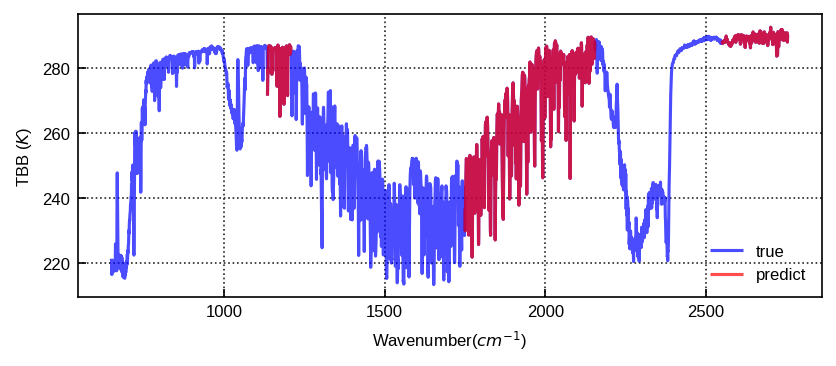

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0000_00.png


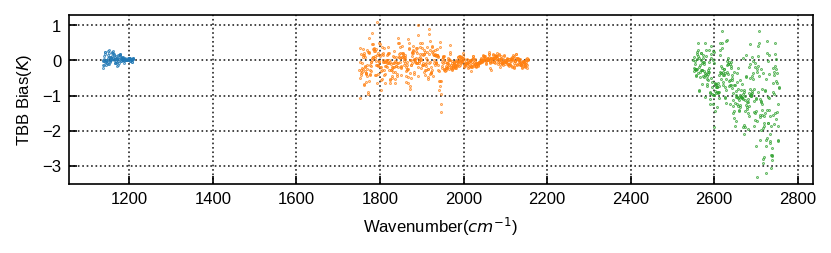

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0000_01.png


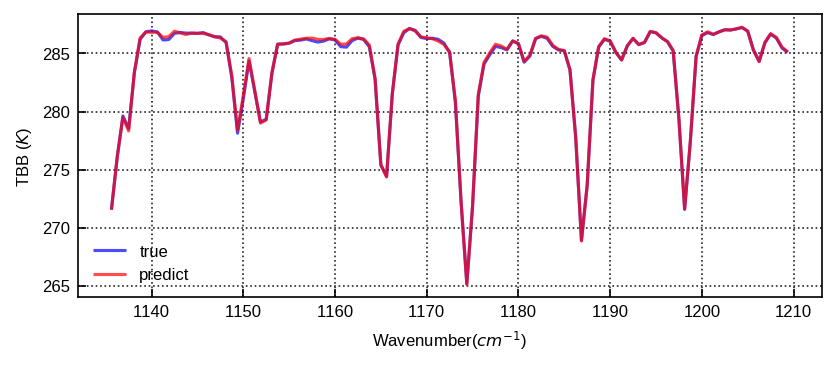

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0000_02.png


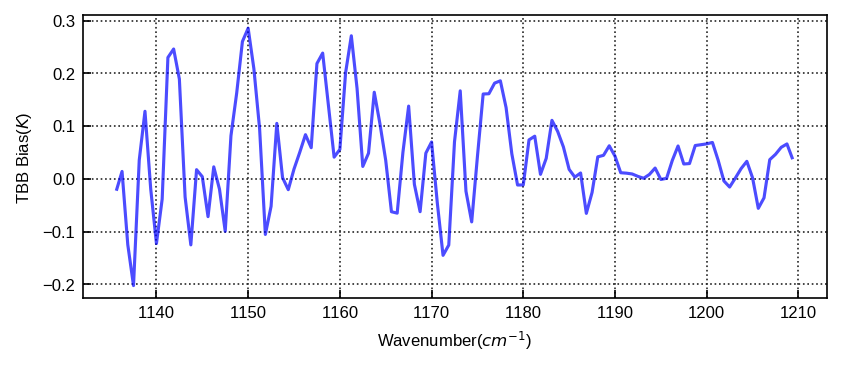

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0000_03.png


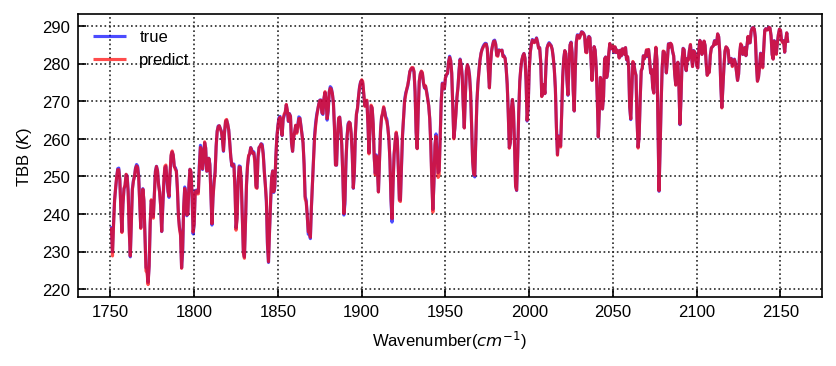

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0000_04.png


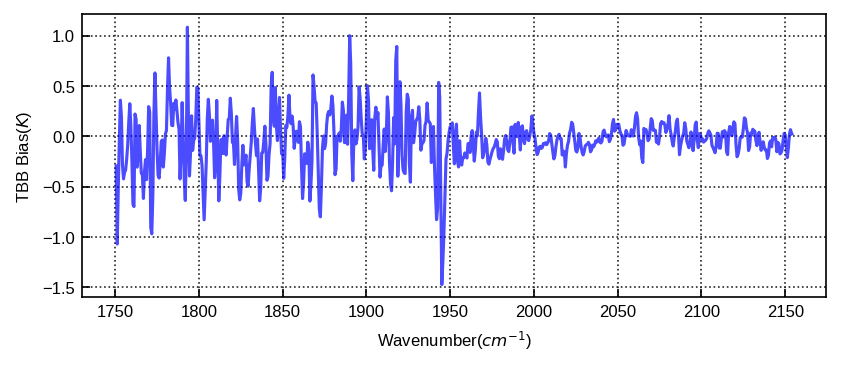

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0000_05.png


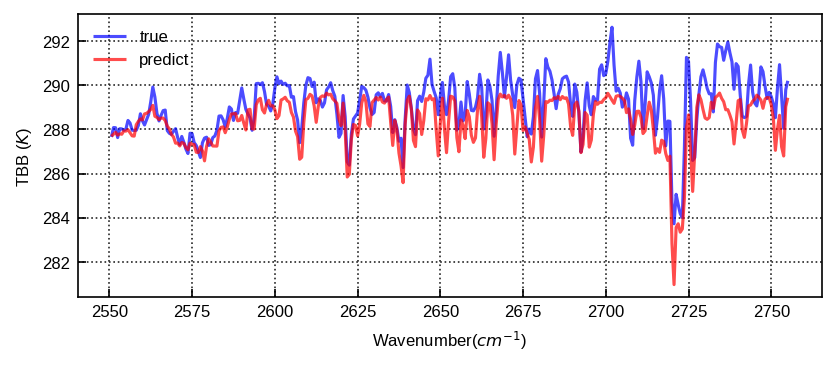

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0000_06.png


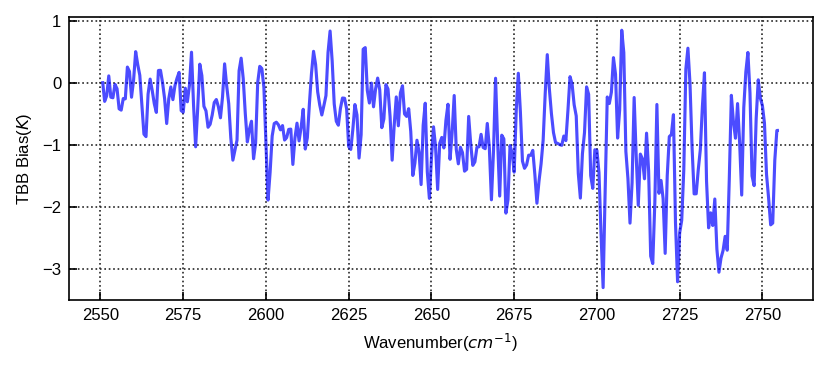

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0000_07.png


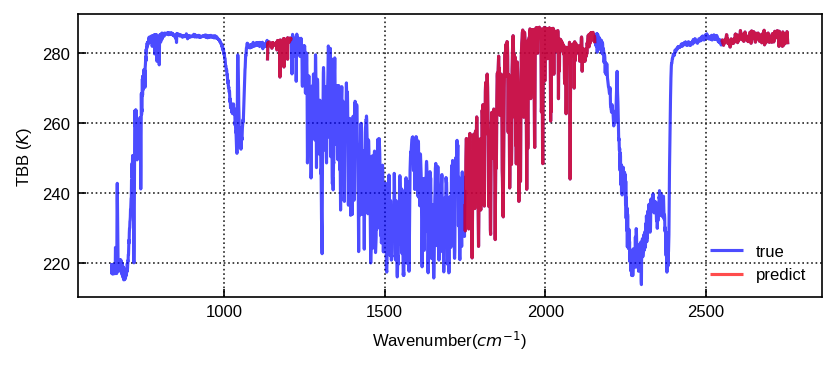

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0001_00.png


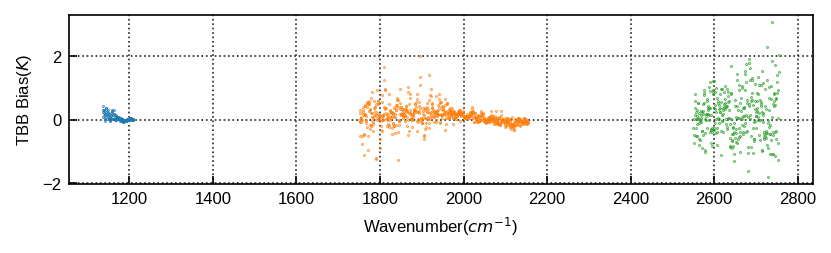

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0001_01.png


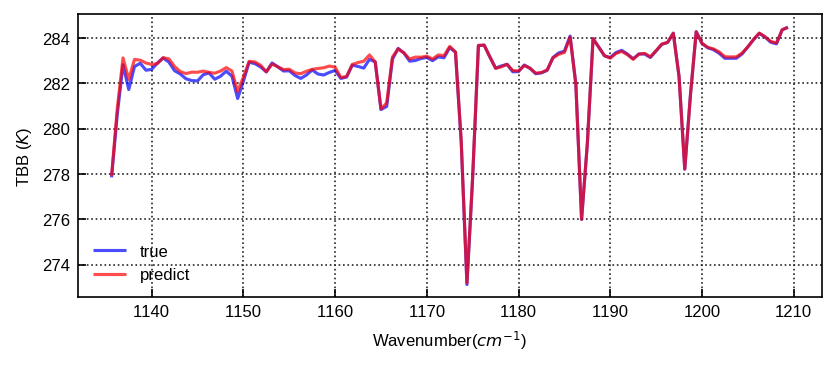

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0001_02.png


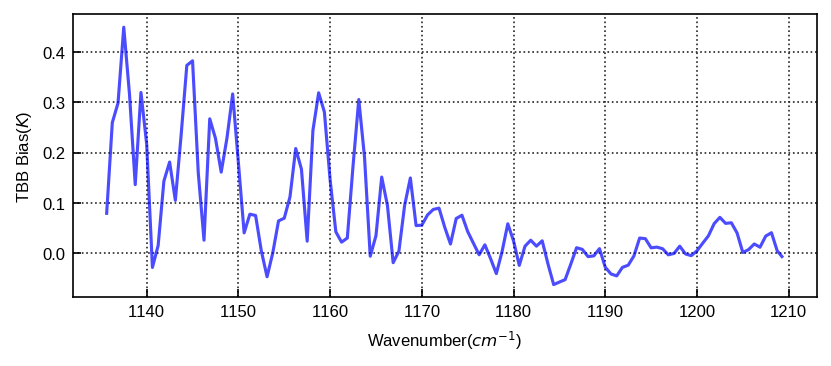

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0001_03.png


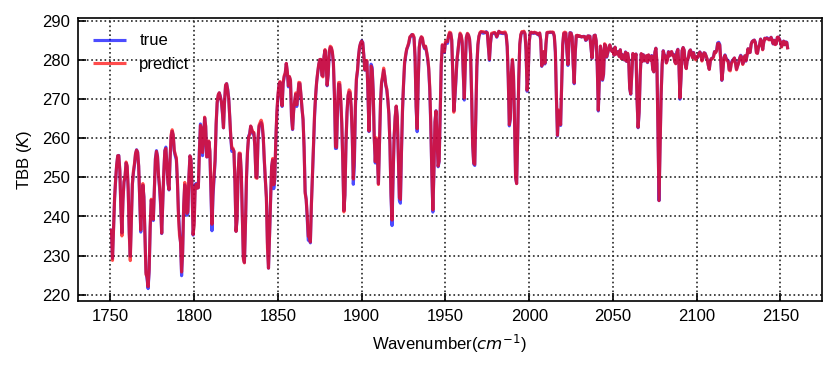

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0001_04.png


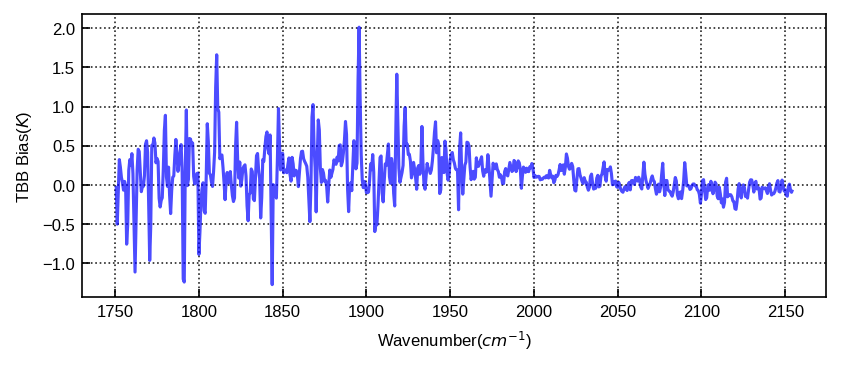

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0001_05.png


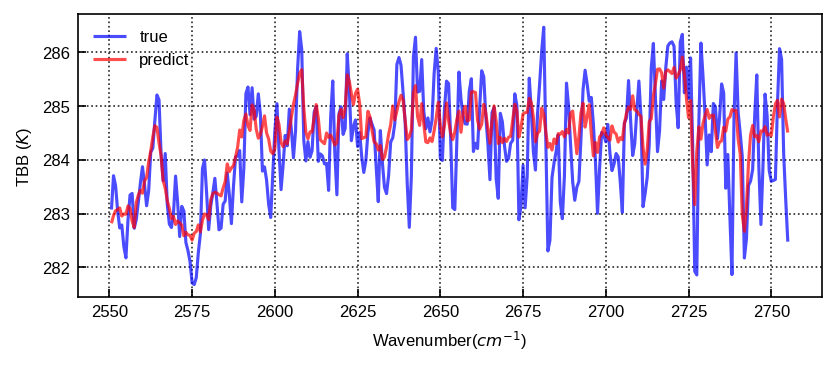

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0001_06.png


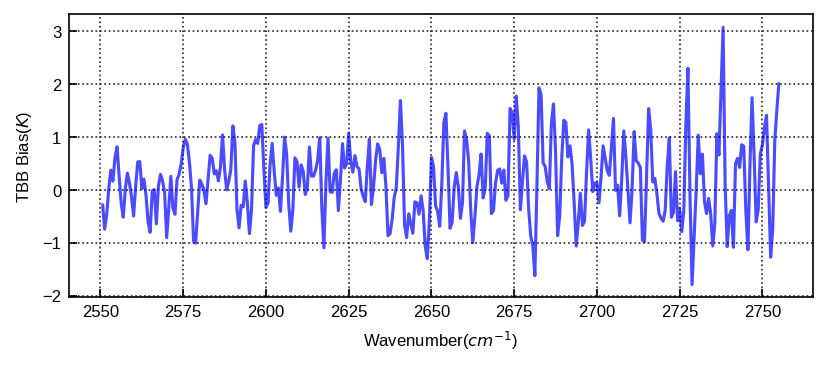

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0001_07.png


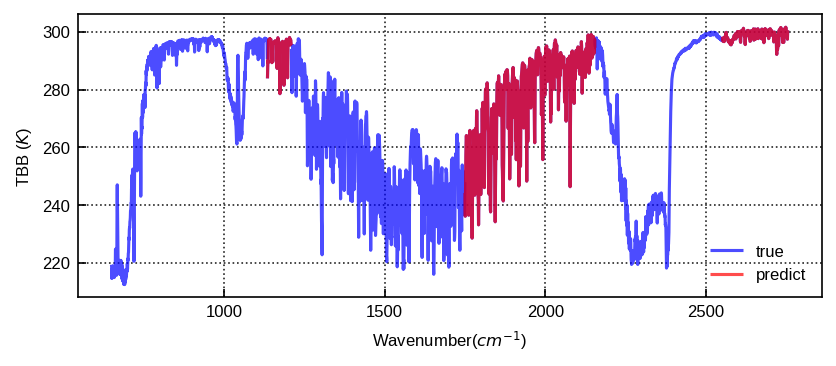

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0002_00.png


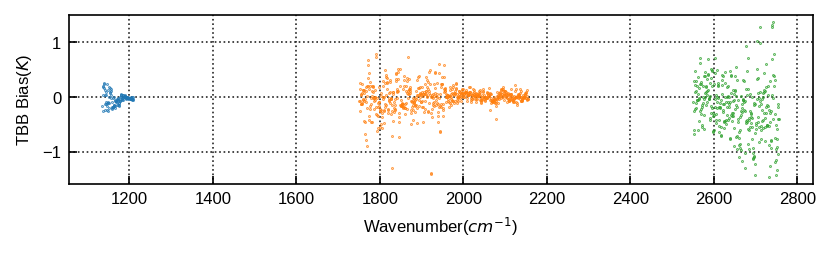

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0002_01.png


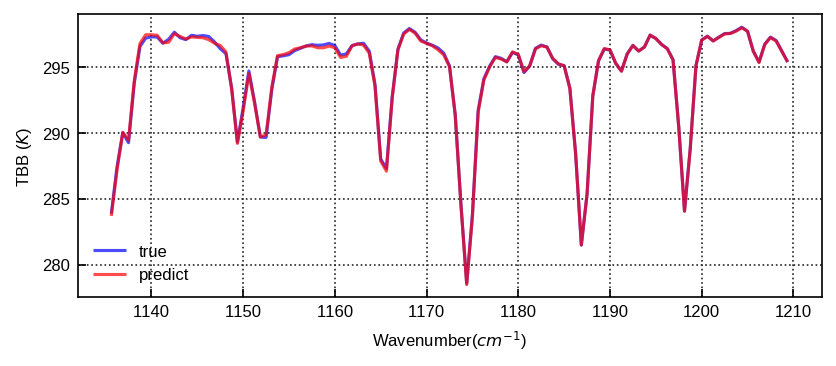

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0002_02.png


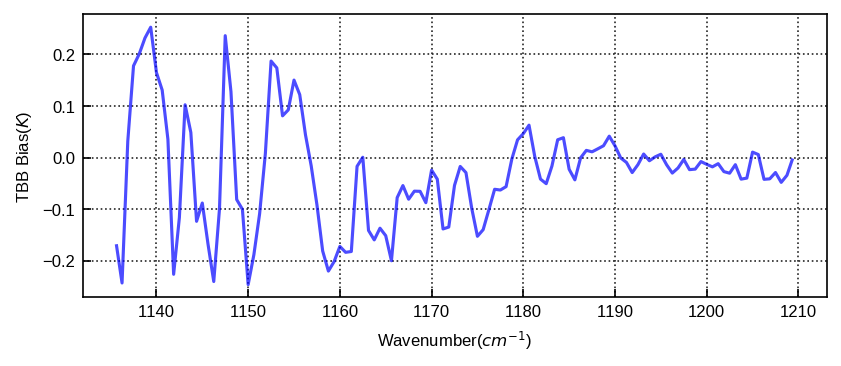

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0002_03.png


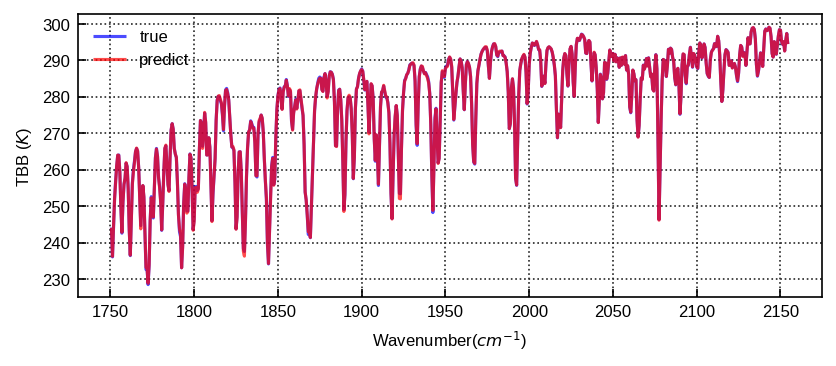

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0002_04.png


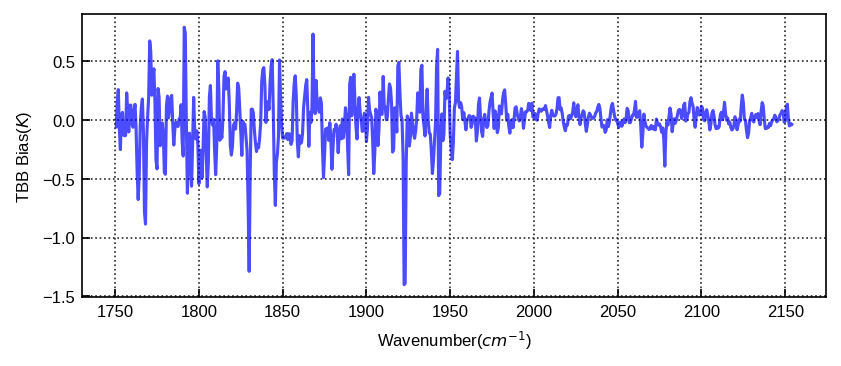

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0002_05.png


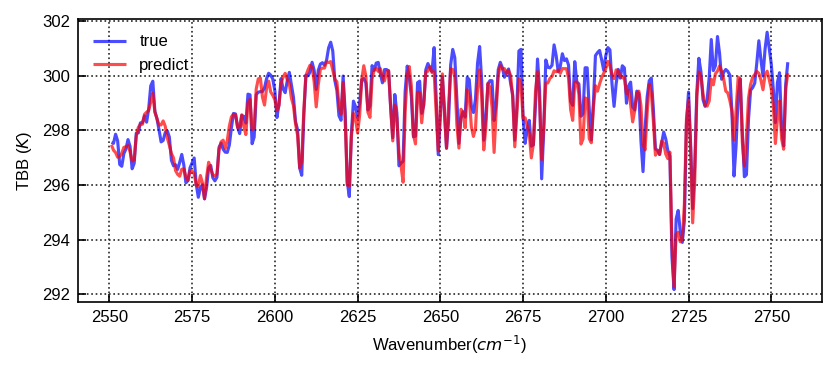

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0002_06.png


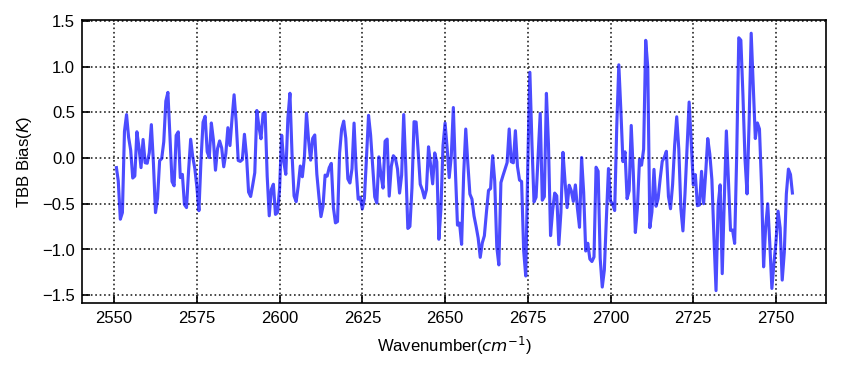

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0002_07.png


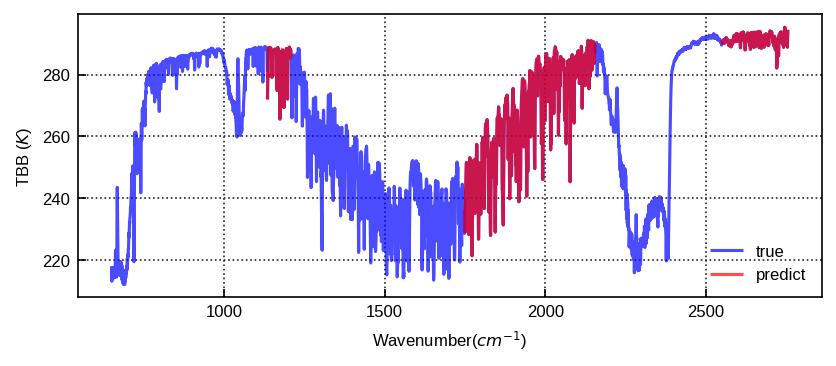

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0003_00.png


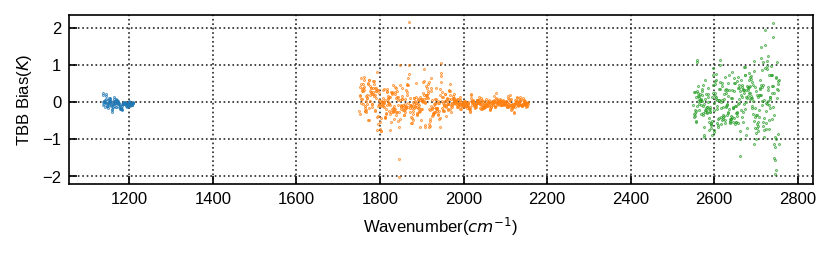

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0003_01.png


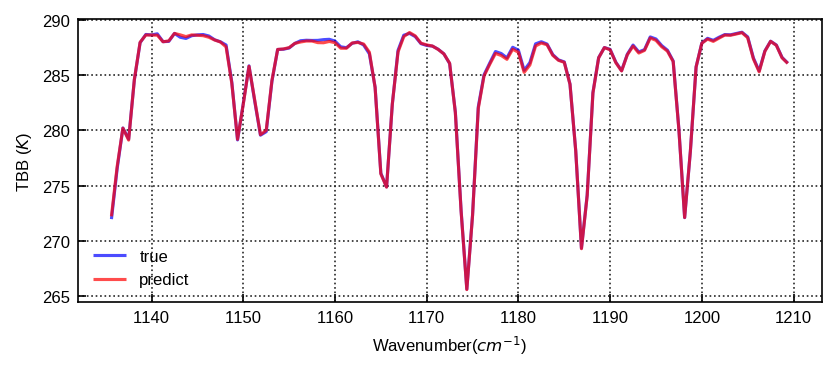

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0003_02.png


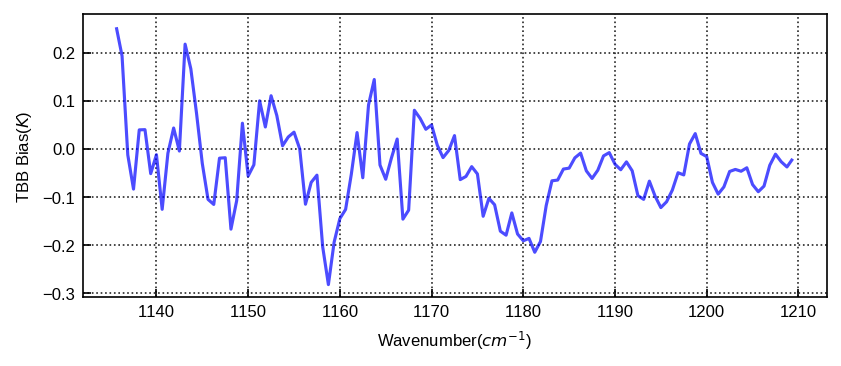

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0003_03.png


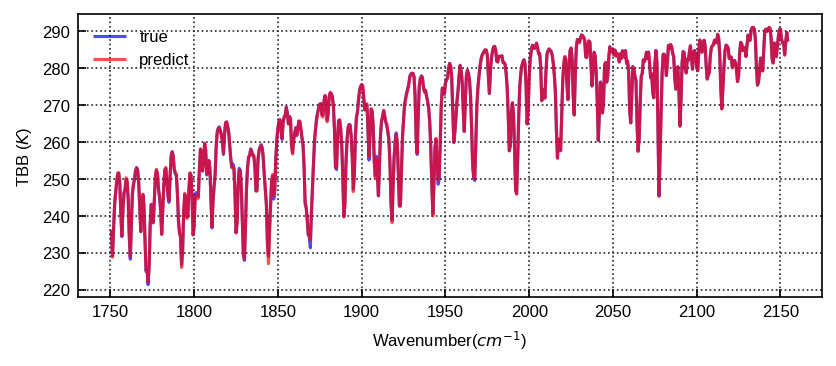

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0003_04.png


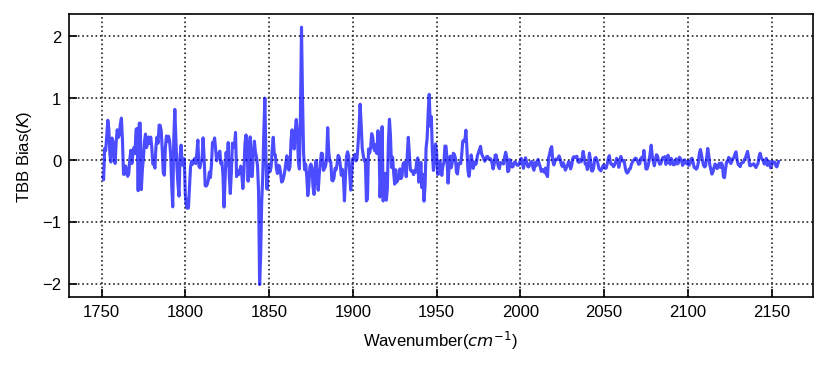

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0003_05.png


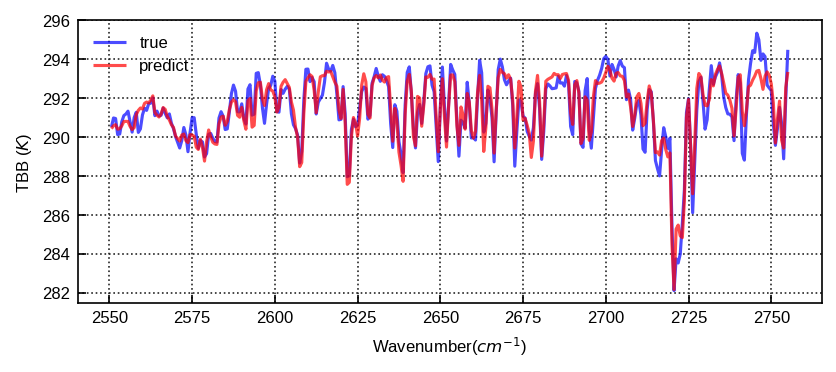

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0003_06.png


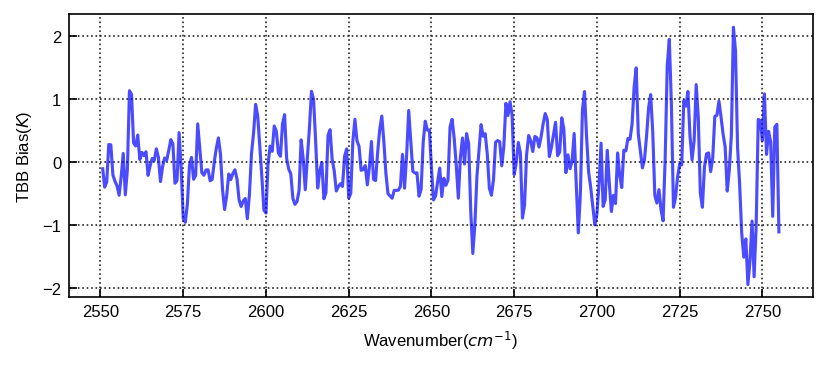

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0003_07.png


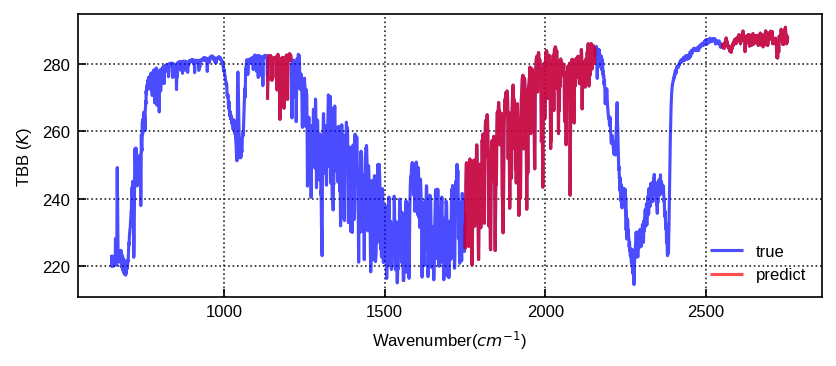

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0004_00.png


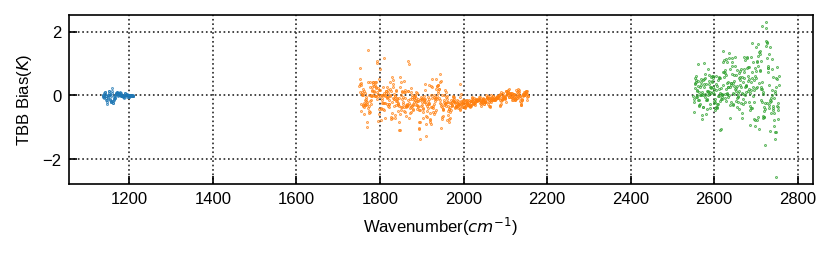

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0004_01.png


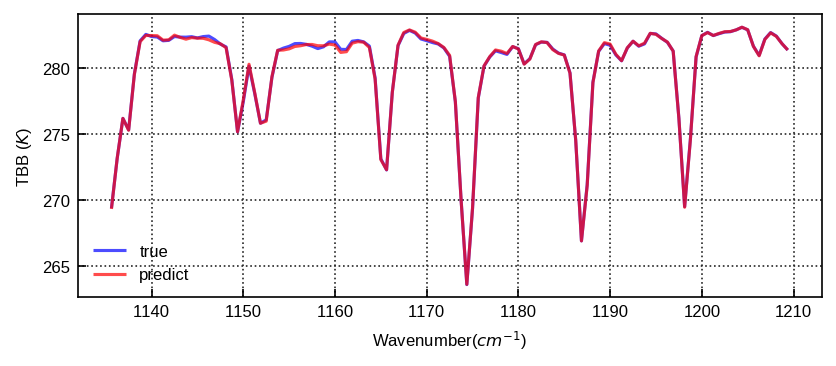

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0004_02.png


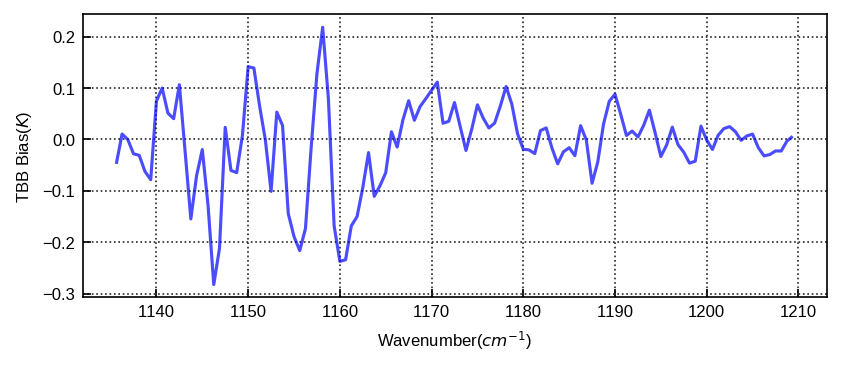

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0004_03.png


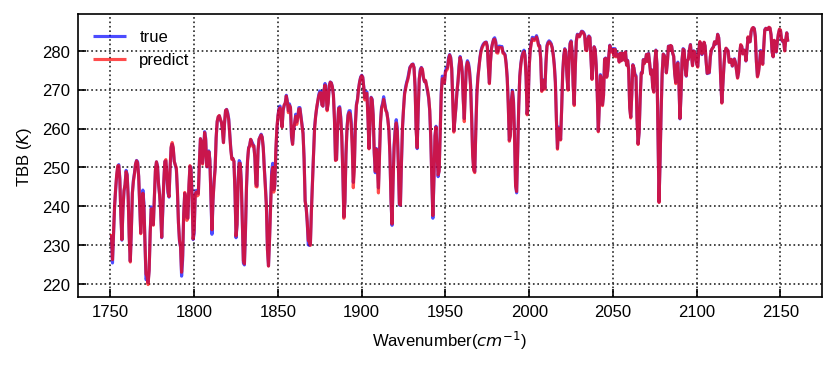

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0004_04.png


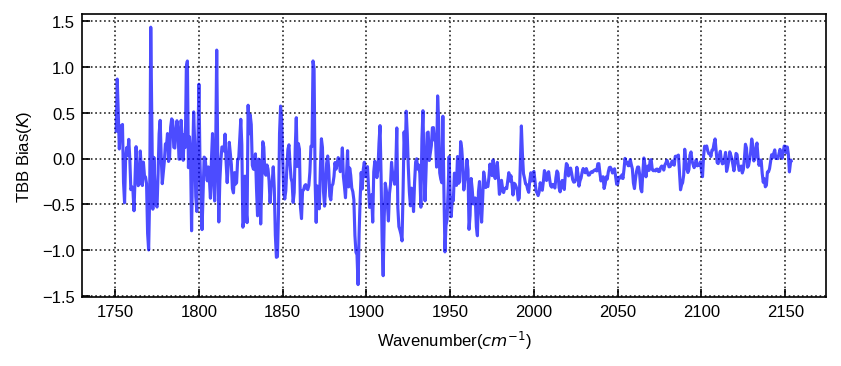

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0004_05.png


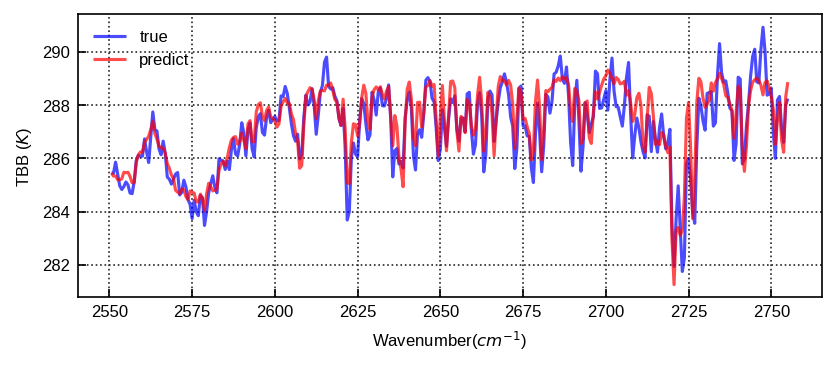

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0004_06.png


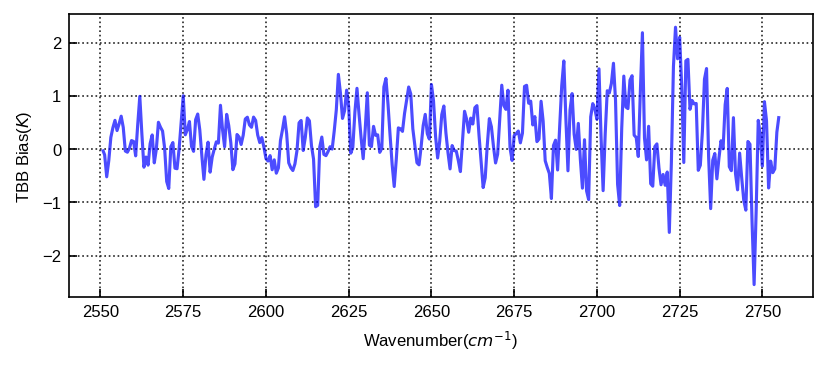

Result/650.0_1135.0_0.625_1210.0_1750.0_0.625_2155.0_2550.0_0.625_1135.625_1209.375_0.625_1750.625_2154.375_0.625_2550.625_2755.0_0.625_dnn/s_0004_07.png


In [63]:
alpha = 0.7

result_dir = 'Result/' + '_'.join([str(j) for i in (ranges_X + ranges_Y) for j in i]) + "_dnn"
if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

file_name = result_dir + '/s_{:04d}_{:02d}.png'

figsize1 = (6.4, 2.5)
figsize2 = (6.4, 1.5)

for data_number in range(0, 5):
    count = 0
    fig = plt.figure(figsize=figsize1, dpi=150)
    plot_true_label = False
    plot_predict_label = False
    for s, e in index_X:
        plt.plot(wavenumber_X[s: e], test_X_tbb[data_number][s: e], c='b', alpha=alpha)
    for s, e in index_Y:
        if plot_true_label:
            label=None
        else:
            label='true'
        plt.plot(wavenumber_Y[s: e], test_Y_tbb[data_number][s: e], c='b', alpha=alpha, label=label)
        plot_true_label = True
    for s, e in index_Y:
        if plot_predict_label:
            label=None
        else:
            label='predict'
        plt.plot(wavenumber_Y[s: e], test_Y_tbb[data_number][s: e], c='r', alpha=alpha, label=label)
        plot_predict_label = True
    plt.xlabel('Wavenumber($cm^{-1}$)')
    plt.ylabel('TBB ($K$)')
    plt.legend()
    plt.show()
    fig.savefig(file_name.format(data_number, count), dpi=150)
    print(file_name.format(data_number, count))
    count += 1

    fig = plt.figure(figsize=figsize2, dpi=150)
    for s, e in index_Y:
        tbb_bias = predict_Y_tbb_linear[data_number][s: e] - test_Y_tbb[data_number][s: e]
        plt.scatter(wavenumber_Y[s: e], tbb_bias, s=0.1)
        plt.xlabel('Wavenumber($cm^{-1}$)')
        plt.ylabel('TBB Bias($K$)')
    plt.show()
    fig.savefig(file_name.format(data_number, count), dpi=150)
    print(file_name.format(data_number, count))
    count += 1

    for s, e in index_Y:
        fig = plt.figure(figsize=figsize1, dpi=150)
        plt.plot(wavenumber_Y[s: e], test_Y_tbb[data_number][s: e], c='b', alpha=alpha, label='true')
        plt.plot(wavenumber_Y[s: e], predict_Y_tbb_linear[data_number][s: e], c='r', alpha=alpha, label='predict')
        plt.xlabel('Wavenumber($cm^{-1}$)')
        plt.ylabel('TBB ($K$)')
        plt.legend()
        plt.show()
        fig.savefig(file_name.format(data_number, count), dpi=150)
        print(file_name.format(data_number, count))
        count += 1
        
        fig = plt.figure(figsize=figsize1, dpi=150)
        plt.plot(wavenumber_Y[s: e], predict_Y_tbb_linear[data_number][s: e]-test_Y_tbb[data_number][s: e], c='b', alpha=alpha)
        plt.xlabel('Wavenumber($cm^{-1}$)')
        plt.ylabel('TBB Bias($K$)')
        plt.show()
        fig.savefig(file_name.format(data_number, count), dpi=150)
        print(file_name.format(data_number, count))
        count += 1